In [1]:
import glob
import os
import yaml
import pandas as pd
from netCDF4 import Dataset
import multiprocessing
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cf
import sys
from matplotlib.collections import PolyCollection
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import pickle
import shap
import time
import re

# Load configuartion file
with open(os.path.join("../config.yml"), "r") as f:
    config = yaml.safe_load(f)
    
# Get utilities
sys.path.insert(1,"../src/")
from utilities import get_tccon_df
    
# Get colorblind friendly colormaps
sys.path.insert(1,"../tools/")
from tol_colors import tol_cmap,tol_cset

# Functions for simple statistics
def r(x,y):
    n = len(x)
    return (n*np.sum(x*y) - np.sum(x)*np.sum(y))/((n*np.sum(x**2)-np.sum(x)**2)*(n*np.sum(y**2)-np.sum(y)**2))**0.5

def rmse(x,y):
    n = len(x)
    return ((1/n)*np.sum((x-y)**2))**0.5
    
# Two function to regrid satellite data onto a regular grid in parallel
def sum_satellite_variable_onto_regular_grid(satellite_file, satellite_var_name, extent, res):
    
    lon_centers = np.arange(extent[0], extent[1]+res[0], res[0])
    lat_centers = np.arange(extent[2], extent[3]+res[1], res[1])
    lon_centers_grid,lat_centers_grid = np.meshgrid(lon_centers,lat_centers)
    
    grid_var = np.zeros_like(lon_centers_grid)
    grid_n = np.zeros_like(lon_centers_grid)
    
    with Dataset(satellite_file) as ds:
        sat_var = ds[satellite_var_name][:]
        sat_lat = ds["latitude"][:]
        sat_lon = ds["longitude"][:]
        
    for i in range(lon_centers_grid.shape[0]):
        for j in range(lon_centers_grid.shape[1]):

            lon_west_grid = lon_centers_grid[i,j] - res[0]/2
            lon_east_grid = lon_centers_grid[i,j] + res[0]/2
            lat_south_grid = lat_centers_grid[i,j] - res[1]/2
            lat_north_grid = lat_centers_grid[i,j] + res[1]/2
            sat_var_in_this_grid_box = (sat_lon > lon_west_grid) & (sat_lon <= lon_east_grid) & (sat_lat > lat_south_grid) & (sat_lat <= lat_north_grid)

            grid_var[i,j] += np.sum(sat_var[sat_var_in_this_grid_box])
            grid_n[i,j] += np.sum(sat_var_in_this_grid_box)
            
    return grid_var, grid_n

def regrid_satellite_variable_onto_regular_grid(satellite_var_name, extent, res, start_dt, end_dt):

    inputs = [(f, satellite_var_name, extent, res) for f in glob.glob(os.path.join(config["StorageDir"], "blended", "*.nc"))
                                                         if pd.Interval(pd.to_datetime(f.split("_")[12]), pd.to_datetime(f.split("_")[13])).
                                                         overlaps(pd.Interval(start_dt,end_dt))]

    with multiprocessing.Pool() as pool:
        results = pool.starmap(sum_satellite_variable_onto_regular_grid, inputs)
        pool.close()
        pool.join()
        
    grid_vars = np.sum([results[i][0] for i in range(len(results))], axis=0)
    grid_ns = np.sum([results[i][1] for i in range(len(results))], axis=0)
    grid_ns[grid_ns == 0] = np.nan

    regridded_sat_var = grid_vars/grid_ns
    regridded_sat_var_n = grid_ns

    lon_centers = np.arange(extent[0], extent[1]+res[0], res[0])
    lat_centers = np.arange(extent[2], extent[3]+res[1], res[1])
    lon_centers_grid,lat_centers_grid = np.meshgrid(lon_centers,lat_centers)
    
    return regridded_sat_var, regridded_sat_var_n, lon_centers_grid, lat_centers_grid

# Function for regridding the paired data (don't need parallel for this; separate function from above because this is a dataframe, not netCDF files)
def regrid_delta_tropomi_gosat_onto_regular_grid(df, var_name, extent, res, start_dt, end_dt):
    
    lon_centers = np.arange(extent[0], extent[1]+res[0], res[0])
    lat_centers = np.arange(extent[2], extent[3]+res[1], res[1])
    lon_centers_grid,lat_centers_grid = np.meshgrid(lon_centers,lat_centers)
    
    grid_var = np.zeros_like(lon_centers_grid)
    grid_n = np.zeros_like(lon_centers_grid)
    
    mask = (df["tropomi_time"] > start_dt) & (df["tropomi_time"] < end_dt)
    sat_var = np.array(df[var_name][mask])
    sat_lat = np.array(df["tropomi_latitude"][mask])
    sat_lon = np.array(df["tropomi_longitude"][mask])
        
    for i in range(lon_centers_grid.shape[0]):
        for j in range(lon_centers_grid.shape[1]):

            lon_west_grid = lon_centers_grid[i,j] - res[0]/2
            lon_east_grid = lon_centers_grid[i,j] + res[0]/2
            lat_south_grid = lat_centers_grid[i,j] - res[1]/2
            lat_north_grid = lat_centers_grid[i,j] + res[1]/2
            sat_var_in_this_grid_box = (sat_lon > lon_west_grid) & (sat_lon <= lon_east_grid) & (sat_lat > lat_south_grid) & (sat_lat <= lat_north_grid)

            grid_var[i,j] += np.sum(sat_var[sat_var_in_this_grid_box])
            grid_n[i,j] += np.sum(sat_var_in_this_grid_box)
            
    grid_n[grid_n == 0] = np.nan
    regridded_sat_var = grid_var/grid_n
    regridded_sat_var_n = grid_n
    
    return regridded_sat_var, regridded_sat_var_n, lon_centers_grid, lat_centers_grid

### Figure 1

In [4]:
def figure01():

    # Regridding argmuents
    var_name = "delta_tropomi_gosat"
    start_dt, end_dt = pd.to_datetime("2018-01-01 00:00:00"), pd.to_datetime("2022-01-01 00:00:00")
    extent1 = (-178.75,178.75,-89,89) # lon_min, lon_max, lat_min, lat_max
    res1 = (2.5,2.0) # lon, lat
    extent2 = (-179.84375,179.84375,-89.875,89.875) # lon_min, lon_max, lat_min, lat_max
    res2 = (0.3125,0.25) # lon, lat
    
    # Regrid all pairs to 2 x 2.5 grid
    df = pd.read_pickle(os.path.join(config["StorageDir"], "processed", "tropomi_gosat_pairs.pkl"))
    regridded_delta_TROPOMI_GOSAT_2_25, _, lon_centers_grid_2_25, lat_centers_grid_2_25 = regrid_delta_tropomi_gosat_onto_regular_grid(df, var_name, extent1, res1, start_dt, end_dt)

    # Regrid all land pairs to 2 x 2.5 and 0.25 x 0.3125 grid
    df = pd.read_pickle(os.path.join(config["StorageDir"], "processed", "tropomi_gosat_pairs.pkl"))
    df = df[(df["tropomi_surface_classification"] == 0) | (df["tropomi_surface_classification"] == 2)]
    regridded_delta_TROPOMI_GOSAT_Land_2_25, _, _, _ = regrid_delta_tropomi_gosat_onto_regular_grid(df, var_name, extent1, res1, start_dt, end_dt)
    regridded_delta_TROPOMI_GOSAT_Land_025_03125, _, _, _ = regrid_delta_tropomi_gosat_onto_regular_grid(df, var_name, extent2, res2, start_dt, end_dt)

    # Regrid all water pairs to 2 x 2.5 and 0.25 x 0.3125 grid
    df = pd.read_pickle(os.path.join(config["StorageDir"], "processed", "tropomi_gosat_pairs.pkl"))
    df = df[(df["tropomi_surface_classification"] == 1) | (df["tropomi_surface_classification"] == 3)]
    regridded_delta_TROPOMI_GOSAT_Water_2_25, _, _, _ = regrid_delta_tropomi_gosat_onto_regular_grid(df, var_name, extent1, res1, start_dt, end_dt)
    regridded_delta_TROPOMI_GOSAT_Water_025_03125, _, _, _ = regrid_delta_tropomi_gosat_onto_regular_grid(df, var_name, extent2, res2, start_dt, end_dt)
    
    # Plot setup
    fig,ax = plt.subplots(figsize=(10,10), subplot_kw={"projection":ccrs.PlateCarree()})
    ax.set_title(f"Observed $\Delta$(TROPOMI-GOSAT) 2018-2021", fontsize=16)
    ax.imshow(np.tile(np.array([[[200, 200, 200]]],dtype=np.uint8), [2, 2, 1]),origin='upper',transform=ccrs.PlateCarree(),extent=[-180, 180, -90, 90])
    ax.coastlines()
    ax.set_global()
    gl = ax.gridlines(draw_labels=True, zorder=-1, linewidth=0)
    gl.top_labels = gl.right_labels = False

    # Plot background (regridded delta(TROPOMI-GOSAT) for 30 Apr 2018 - 31 Dec 2021)
    cb = ax.pcolormesh(lon_centers_grid_2_25, lat_centers_grid_2_25, regridded_delta_TROPOMI_GOSAT_2_25, cmap=tol_cmap("BuRd"), vmin=-30.0, vmax=30.0)
    cbar = plt.colorbar(cb, location="bottom", aspect=30, pad=0.052, shrink=0.5, extend="both", label=f"$\Delta$XCH$_4$ [ppb]")
    cbar.ax.tick_params(labelsize=12)
    cbar.ax.set_xlabel(f"$\Delta$XCH$_4$ [ppb]", fontsize=12)

    # Add table of values for 0.25 x 0.3125
    col_labels=[r'$0.25\degree \times 0.3125\degree$','Land','Water']
    table_vals=[["Mean Bias",f"{np.nanmean(regridded_delta_TROPOMI_GOSAT_Land_025_03125):.1f} ppb", f"{np.nanmean(regridded_delta_TROPOMI_GOSAT_Water_025_03125):.1f} ppb"],\
                ["Variable Bias",f"{np.nanstd(regridded_delta_TROPOMI_GOSAT_Land_025_03125):.1f} ppb", f"{np.nanstd(regridded_delta_TROPOMI_GOSAT_Water_025_03125):.1f} ppb"]]
    table = plt.table(cellText=table_vals,
                      colWidths = [0.09]*3,
                      colLabels=col_labels,
                      colColours=["#dedede","white","white"],
                      cellLoc="center",
                      rowLoc="center",
                      bbox=[0.02,0.02,0.45,0.13],
                      zorder=2)
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    # Add table of values for 2 x 2.5
    col_labels=[r'$2\degree \times 2.5\degree$','Land','Water']
    table_vals=[["Mean Bias",f"{np.nanmean(regridded_delta_TROPOMI_GOSAT_Land_2_25):.1f} ppb", f"{np.nanmean(regridded_delta_TROPOMI_GOSAT_Water_2_25):.1f} ppb"],\
                ["Variable Bias",f"{np.nanstd(regridded_delta_TROPOMI_GOSAT_Land_2_25):.1f} ppb", f"{np.nanstd(regridded_delta_TROPOMI_GOSAT_Water_2_25):.1f} ppb"]]
    table = plt.table(cellText=table_vals,
                      colWidths = [0.09]*3,
                      colLabels=col_labels,
                      colColours=["#dedede","white","white"],
                      cellLoc="center",
                      rowLoc="center",
                      bbox=[0.53,0.02,0.45,0.13],
                      zorder=2)
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    return fig

Figure 01 generated in 0.09 hours.


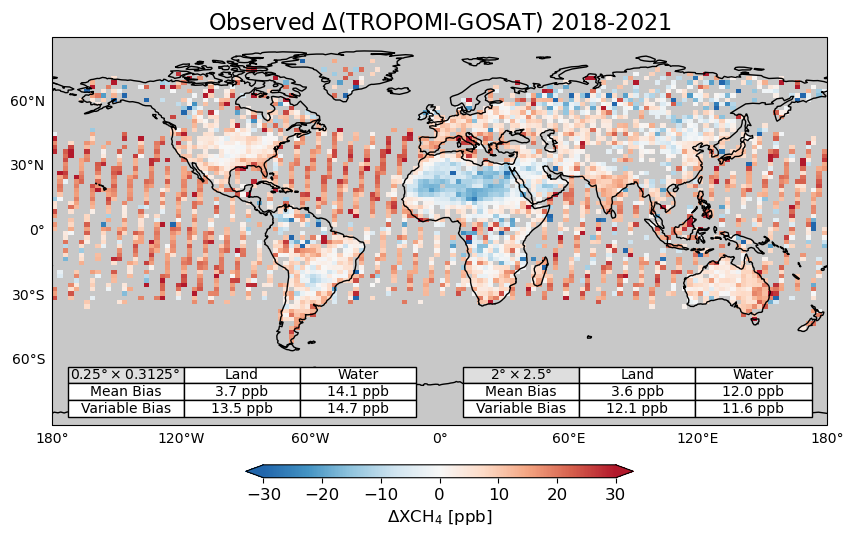

In [5]:
start_time = time.time()
fig01 = figure01()
print(f"Figure 01 generated in {(time.time()-start_time)/3600:.2f} hours.")
fig01.savefig(os.path.join(config["RunDir"], "notebooks", "paper_figures", "fig01.png"), bbox_inches="tight", dpi=300)

### Figure 2

In [4]:
def figure02():

    # Load shap values from run_flaml_and_shap.py
    with open(config["StorageDir"] + "/processed/shap_values_train.pkl", "rb") as handle:
        shap_values_train = pickle.load(handle)

    # Write figure-appropriate names for the SHAP values
    new_feature_names = []
    new_feature_names_dict = {"tropomi_solar_zenith_angle":"Solar Zenith Angle","tropomi_relative_azimuth_angle":"Relative Azimuth Angle",
                              "tropomi_across_track_pixel_index":"Across-Track Pixel Index", "tropomi_surface_classification":"Surface Classification",
                              "tropomi_surface_altitude":"Surface Altitude","tropomi_surface_altitude_precision":"Surface Altitude Precision",
                              "tropomi_eastward_wind":"Eastward Wind","tropomi_northward_wind":"Northward Wind","tropomi_xch4_apriori":"XCH$_4$ $a$ $priori$",
                              "tropomi_reflectance_cirrus_VIIRS_SWIR":"Cirrus Reflectance",
                              "tropomi_xch4_precision":"XCH$_4$ Precision","tropomi_fluorescence":"Fluorescence",
                              "tropomi_co_column":"CO Column","tropomi_co_column_precision":"CO Column Precision",
                              "tropomi_h2o_column":"H$_2$O Column","tropomi_h2o_column_precision":"H$_2$O Column Precision",
                              "tropomi_aerosol_size":"Aerosol Size Distribution Parameter","tropomi_aerosol_size_precision":"Aerosol Size Distribution Parameter Precision",
                              "tropomi_aerosol_height":"Aerosol Height","tropomi_aerosol_height_precision":"Aerosol Height Precision",
                              "tropomi_aerosol_column":"Aerosol Column","tropomi_aerosol_column_precision":"Aerosol Column Precision",
                              "tropomi_surface_albedo_SWIR":"SWIR Surface Albedo","tropomi_surface_albedo_SWIR_precision":"SWIR Surface Albedo Precision",
                              "tropomi_surface_albedo_NIR":"NIR Surface Albedo", "tropomi_surface_albedo_NIR_precision":"NIR Surface Albedo Precision",
                              "tropomi_aerosol_optical_thickness_SWIR":"SWIR Aerosol Optical Thickness","tropomi_aerosol_optical_thickness_NIR":"NIR Aerosol Optical Thickness",
                              "tropomi_chi_square_SWIR":"SWIR Chi-Squared","tropomi_chi_square_NIR":"NIR Chi-Squared"}

    for key in shap_values_train.feature_names:
        new_feature_names.append(new_feature_names_dict[key])
    shap_values_train.feature_names = new_feature_names
    
    # Calculate 25th, 50th, and 75th percentiles for each feature
    median_abs_shap = np.zeros((len(shap_values_train.feature_names)))
    perc_25_abs_shap = np.zeros((len(shap_values_train.feature_names)))
    perc_75_abs_shap = np.zeros((len(shap_values_train.feature_names)))

    for idx,key in enumerate(shap_values_train.feature_names):
        median_abs_shap[idx] = np.percentile(np.abs(shap_values_train[:,key].values), 50)
        perc_25_abs_shap[idx] = np.percentile(np.abs(shap_values_train[:,key].values), 25)
        perc_75_abs_shap[idx] = np.percentile(np.abs(shap_values_train[:,key].values), 75)

    abs_shap = pd.DataFrame({"feature_names":shap_values_train.feature_names,"median_abs_shap":median_abs_shap,"perc_25_abs_shap":perc_25_abs_shap,"perc_75_abs_shap":perc_75_abs_shap})
    
    # Plot the 10 most important variables (as ranked by their median absolute SHAP values)
    abs_shap_subset = abs_shap.sort_values("median_abs_shap").iloc[-10:]
    fig,ax = plt.subplots(figsize=(7,5))

    ax.grid(linewidth=0.2)
    ax.scatter(abs_shap_subset["median_abs_shap"],abs_shap_subset["feature_names"],s=100,label="Median",color="#4477AA",marker="d",edgecolor="k",zorder=10)
    for i in abs_shap_subset.index:
        if abs_shap_subset.loc[i,"feature_names"] == "Surface Altitude":
            ax.plot([abs_shap_subset.loc[i,"perc_25_abs_shap"],abs_shap_subset.loc[i,"perc_75_abs_shap"]],[abs_shap_subset.loc[i,"feature_names"],abs_shap_subset.loc[i,"feature_names"]],color="#4477AA", label=r"IQR")
        else:
            ax.plot([abs_shap_subset.loc[i,"perc_25_abs_shap"],abs_shap_subset.loc[i,"perc_75_abs_shap"]],[abs_shap_subset.loc[i,"feature_names"],abs_shap_subset.loc[i,"feature_names"]],color="#4477AA")
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.set_xlabel("Absolute SHAP Value [ppb]", fontsize=13)
    ax.legend(loc="lower right",fontsize=13)

    return fig

Figure 02 generated in 0.00 hours.


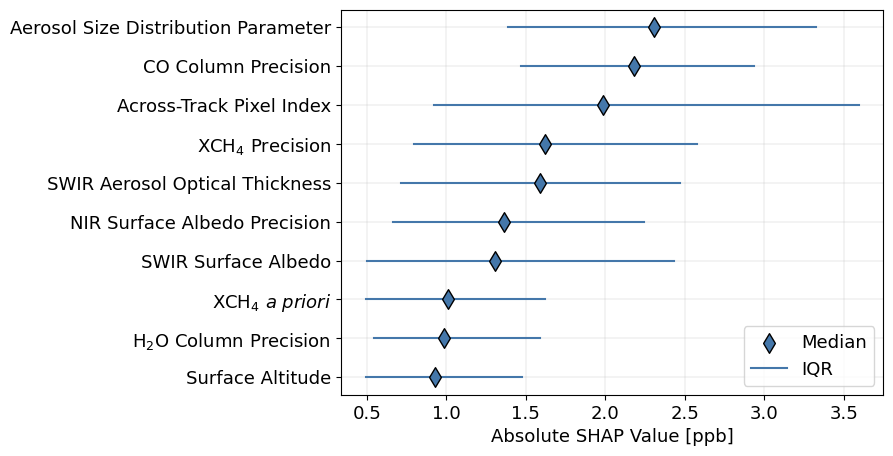

In [5]:
start_time = time.time()
fig02 = figure02()
print(f"Figure 02 generated in {(time.time()-start_time)/3600:.2f} hours.")
fig02.savefig(os.path.join(config["RunDir"], "notebooks", "paper_figures", "fig02.png"), bbox_inches="tight", dpi=300)

### Figure 3

In [6]:
def figure03():

    # Load shap values from run_flaml_and_shap.py
    with open(config["StorageDir"] + "/processed/shap_values_train.pkl", "rb") as handle:
        shap_values_train = pickle.load(handle)

    # Plot aerosol size distribution parameter SHAP dependence plots
    fig,ax = plt.subplots(1,2,figsize=(14,8),sharey=True)

    ax[0].axhline(0,linestyle="--",color="k",zorder=-1)
    ax[0].hexbin(shap_values_train[:,"tropomi_aerosol_size"].data, shap_values_train[:,"tropomi_aerosol_size"].values, gridsize=75, bins='log', cmap=tol_cmap("rainbow_PuBr"), vmin=1, vmax=2000)
    ax[0].set_xlabel("TROPOMI Aerosol Size Distribution Parameter",fontsize=13)
    ax[0].set_ylabel("SHAP Contribution to $\Delta$(TROPOMI-GOSAT) [ppb]",fontsize=13)
    ax[0].tick_params(axis='both', which='major', labelsize=12)
    ax[0].set_ylim([-22,10])

    # Plot SWIR surface albedo SHAP dependence plots
    ax[1].axhline(0,linestyle="--",color="k",zorder=-1)
    hb = ax[1].hexbin(shap_values_train[:,"tropomi_surface_albedo_SWIR"].data, shap_values_train[:,"tropomi_surface_albedo_SWIR"].values, gridsize=75, bins='log', cmap=tol_cmap("rainbow_PuBr"), vmin=1, vmax=2000)
    ax[1].set_xlabel("TROPOMI SWIR Surface Albedo",fontsize=13)
    ax[1].tick_params(axis='both', which='major', labelsize=12)
    ax[1].set_ylim([-22,10])

    # Adjust spacing and add colorbar
    fig.subplots_adjust(wspace=0.1)
    cb = fig.colorbar(hb, ax=ax, location="bottom", pad=0.13, aspect=25, shrink=0.3)
    cb.set_label("Counts", fontsize=12)
    cb.ax.tick_params(labelsize=12) 

    return fig

Figure 03 generated in 0.00 hours.


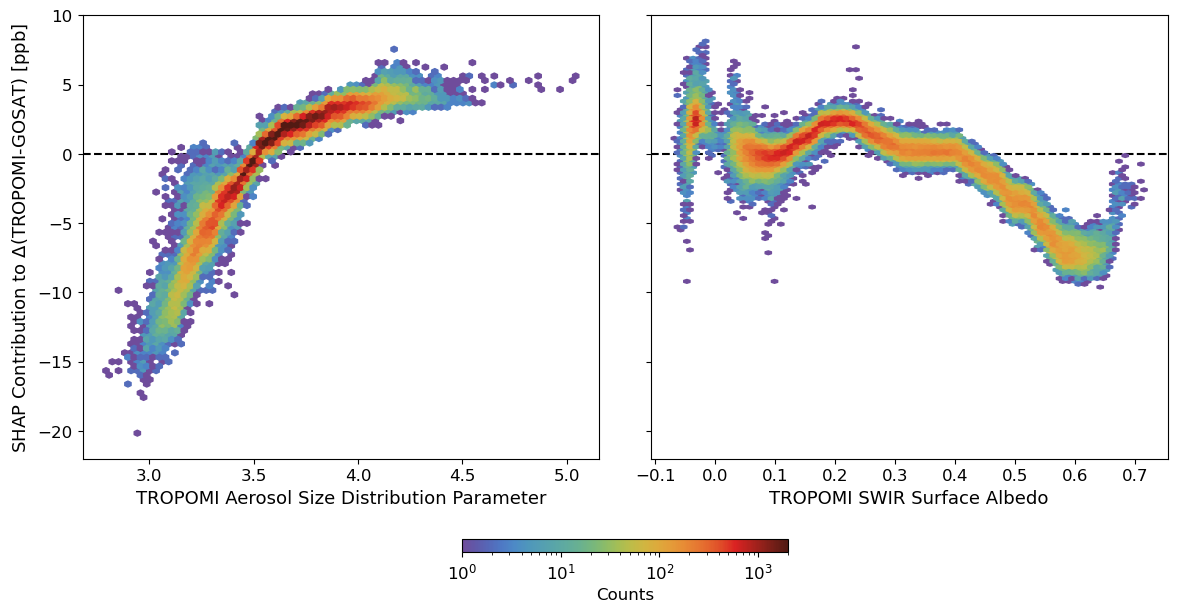

In [7]:
start_time = time.time()
fig03 = figure03()
print(f"Figure 03 generated in {(time.time()-start_time)/3600:.2f} hours.")
fig03.savefig(os.path.join(config["RunDir"], "notebooks", "paper_figures", "fig03.png"), bbox_inches="tight", dpi=300)

### Figure 4

In [8]:
def figure04():

    # Read in TROPOMI+GOSAT pairs
    tropomi_gosat_pairs = pd.read_pickle(os.path.join(config["StorageDir"], "processed", "tropomi_gosat_pairs.pkl"))

    # Subset to just the predictor variables
    X = tropomi_gosat_pairs[["tropomi_solar_zenith_angle","tropomi_relative_azimuth_angle","tropomi_across_track_pixel_index",
                             "tropomi_surface_classification","tropomi_surface_altitude","tropomi_surface_altitude_precision",
                             "tropomi_eastward_wind","tropomi_northward_wind","tropomi_xch4_apriori","tropomi_reflectance_cirrus_VIIRS_SWIR",
                             "tropomi_xch4_precision","tropomi_fluorescence","tropomi_co_column","tropomi_co_column_precision",
                             "tropomi_h2o_column","tropomi_h2o_column_precision","tropomi_aerosol_size","tropomi_aerosol_size_precision",
                             "tropomi_aerosol_height","tropomi_aerosol_height_precision","tropomi_aerosol_column","tropomi_aerosol_column_precision",
                             "tropomi_surface_albedo_SWIR","tropomi_surface_albedo_SWIR_precision","tropomi_surface_albedo_NIR",
                             "tropomi_surface_albedo_NIR_precision","tropomi_aerosol_optical_thickness_SWIR","tropomi_aerosol_optical_thickness_NIR",
                             "tropomi_chi_square_SWIR","tropomi_chi_square_NIR"]]
    
    # Get the predicted variable (truth)
    y = tropomi_gosat_pairs["delta_tropomi_gosat"]

    # Split into training + test just as we did in run_flaml_and_shap.py
    train_index = tropomi_gosat_pairs[tropomi_gosat_pairs["tropomi_time"] < pd.to_datetime("2021-01-01")].index
    X_train = X.loc[train_index]
    y_train = y.loc[train_index]

    test_index = tropomi_gosat_pairs[tropomi_gosat_pairs["tropomi_time"] >= pd.to_datetime("2021-01-01")].index
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]

    # Load the model from run_flaml_and_shap.py and use it to make predictions
    with open(os.path.join(config["StorageDir"], "processed", f"model_{config['Model']}.pkl"), "rb") as handle:
        model = pickle.load(handle)
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    # Perform the z-score transform on the predictions (and make sure this matches what is in the config file and thus was used to write blended files)
    a = np.std(y_train)/np.std(y_train_pred)
    b = np.mean(y_train) - a*np.mean(y_train_pred)
    assert (config["a"] == np.round(a,2))
    assert (config["b"] == np.round(b,2))
    
    # Plot the predicted versus true delta(TROPOMI-GOSAT)
    fig,ax = plt.subplots(figsize=(6,6),subplot_kw={"box_aspect":1})

    ax.grid(linewidth=0.2)
    ax.set_axisbelow(True)
    xplot,yplot = y_test, config["a"]*y_test_pred + config["b"]
    min_,max_ = min(np.min(xplot),np.min(yplot)),max(np.max(xplot),np.max(yplot))
    hb = ax.hexbin(xplot, yplot, gridsize=75, bins='log', cmap=tol_cmap("rainbow_PuBr"))
    ax.plot([min_,max_],[min_,max_],linestyle="--",color="k",label="1:1")
    ax.set(xlim=[min_,max_], ylim=[min_,max_])
    ax.set_xlabel(f"Observed $\Delta$(TROPOMI-GOSAT) [ppb]", fontsize=13)
    ax.set_ylabel(f"Predicted $\Delta$(TROPOMI-GOSAT) [ppb]", fontsize=13)
    ax.text(0.03, 0.86, f"R$^2$ = {r(xplot,yplot)**2:.2f}\nRMSE = {rmse(xplot,yplot):.1f} ppb", transform=ax.transAxes, fontsize=13, weight="bold")
    ax.legend(loc="lower right",fontsize=13)
    ax.tick_params(axis='both', which='major', labelsize=12)

    left, bottom, width, height = ax.get_position().bounds
    cax = fig.add_axes([left, -0.05, width, height*0.04])
    cb = plt.colorbar(hb, orientation='horizontal', cax=cax)
    cb.set_label("Counts", fontsize=13)
    cb.ax.tick_params(labelsize=13)
    
    return fig

Figure 04 generated in 0.10 hours.


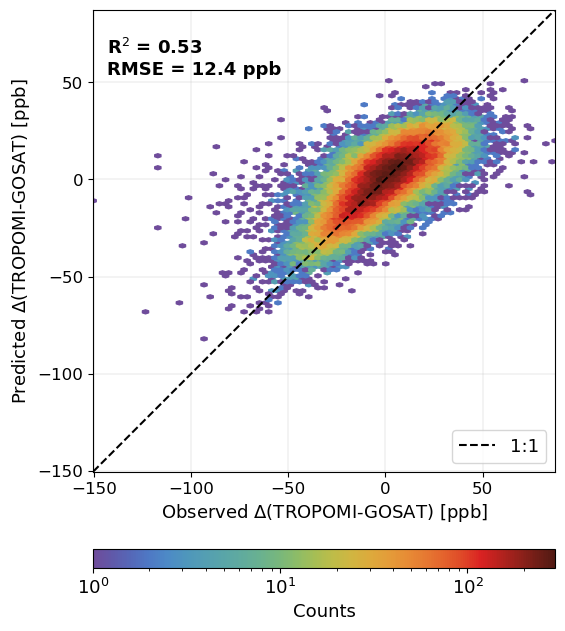

In [9]:
start_time = time.time()
fig04 = figure04()
print(f"Figure 04 generated in {(time.time()-start_time)/3600:.2f} hours.")
fig04.savefig(os.path.join(config["RunDir"], "notebooks", "paper_figures", "fig04.png"), bbox_inches="tight", dpi=300)

### Figure 5

In [10]:
def figure05():

    # Arguments for regridded
    var_name1 = "delta_tropomi_gosat"
    var_name2 = "predicted_delta_tropomi_gosat"
    start_dt, end_dt = pd.to_datetime("2021-01-01 00:00:00"), pd.to_datetime("2022-01-01 00:00:00")
    extent1 = (-178.75,178.75,-89,89) # lon_min, lon_max, lat_min, lat_max
    res1 = (2.5,2.0) # lon, lat
    extent2 = (-179.84375,179.84375,-89.875,89.875) # lon_min, lon_max, lat_min, lat_max
    res2 = (0.3125,0.25) # lon, lat
    
    # Get a dataframe of the TROPOMI+GOSAT pairs and add the predicted delta(TROPOMI-GOSAT)
    tropomi_gosat_pairs = pd.read_pickle(os.path.join(config["StorageDir"], "processed", "tropomi_gosat_pairs.pkl"))

    X = tropomi_gosat_pairs[["tropomi_solar_zenith_angle","tropomi_relative_azimuth_angle","tropomi_across_track_pixel_index",
                             "tropomi_surface_classification","tropomi_surface_altitude","tropomi_surface_altitude_precision",
                             "tropomi_eastward_wind","tropomi_northward_wind","tropomi_xch4_apriori","tropomi_reflectance_cirrus_VIIRS_SWIR",
                             "tropomi_xch4_precision","tropomi_fluorescence","tropomi_co_column","tropomi_co_column_precision",
                             "tropomi_h2o_column","tropomi_h2o_column_precision","tropomi_aerosol_size","tropomi_aerosol_size_precision",
                             "tropomi_aerosol_height","tropomi_aerosol_height_precision","tropomi_aerosol_column","tropomi_aerosol_column_precision",
                             "tropomi_surface_albedo_SWIR","tropomi_surface_albedo_SWIR_precision","tropomi_surface_albedo_NIR",
                             "tropomi_surface_albedo_NIR_precision","tropomi_aerosol_optical_thickness_SWIR","tropomi_aerosol_optical_thickness_NIR",
                             "tropomi_chi_square_SWIR","tropomi_chi_square_NIR"]]

    with open(os.path.join(config["StorageDir"], "processed", f"model_{config['Model']}.pkl"), "rb") as handle:
        model = pickle.load(handle)

    tropomi_gosat_pairs["predicted_delta_tropomi_gosat"] = config["a"]*model.predict(X) + config["b"]
    
    # Regrid all pairs to 2 x 2.5 grid
    df = tropomi_gosat_pairs
    regridded_delta_TROPOMI_GOSAT_2_25, _, lon_centers_grid_2_25, lat_centers_grid_2_25 = regrid_delta_tropomi_gosat_onto_regular_grid(df, var_name1, extent1, res1, start_dt, end_dt)
    regridded_pred_delta_TROPOMI_GOSAT_2_25, _, _, _ = regrid_delta_tropomi_gosat_onto_regular_grid(df, var_name2, extent1, res1, start_dt, end_dt)
    
    # Regrid all land pairs to 2 x 2.5 and 0.25 x 0.3125 grid
    df = tropomi_gosat_pairs[(tropomi_gosat_pairs["tropomi_surface_classification"] == 0) | (tropomi_gosat_pairs["tropomi_surface_classification"] == 2)]
    regridded_delta_TROPOMI_GOSAT_Land_2_25, _, _, _ = regrid_delta_tropomi_gosat_onto_regular_grid(df, var_name1, extent1, res1, start_dt, end_dt)
    regridded_delta_TROPOMI_GOSAT_Land_025_03125, _, _, _ = regrid_delta_tropomi_gosat_onto_regular_grid(df, var_name1, extent2, res2, start_dt, end_dt)
    regridded_pred_delta_TROPOMI_GOSAT_Land_2_25, _, _, _ = regrid_delta_tropomi_gosat_onto_regular_grid(df, var_name2, extent1, res1, start_dt, end_dt)
    regridded_pred_delta_TROPOMI_GOSAT_Land_025_03125, _, _, _ = regrid_delta_tropomi_gosat_onto_regular_grid(df, var_name2, extent2, res2, start_dt, end_dt)
    
    # Regrid all water pairs to 2 x 2.5 and 0.25 x 0.3125 grid
    df = tropomi_gosat_pairs[(tropomi_gosat_pairs["tropomi_surface_classification"] == 1) | (tropomi_gosat_pairs["tropomi_surface_classification"] == 3)]
    regridded_delta_TROPOMI_GOSAT_Water_2_25, _, _, _ = regrid_delta_tropomi_gosat_onto_regular_grid(df, var_name1, extent1, res1, start_dt, end_dt)
    regridded_delta_TROPOMI_GOSAT_Water_025_03125, _, _, _ = regrid_delta_tropomi_gosat_onto_regular_grid(df, var_name1, extent2, res2, start_dt, end_dt)
    regridded_pred_delta_TROPOMI_GOSAT_Water_2_25, _, _, _ = regrid_delta_tropomi_gosat_onto_regular_grid(df, var_name2, extent1, res1, start_dt, end_dt)
    regridded_pred_delta_TROPOMI_GOSAT_Water_025_03125, _, _, _ = regrid_delta_tropomi_gosat_onto_regular_grid(df, var_name2, extent2, res2, start_dt, end_dt)
    
    # General plot formatting
    fig,ax = plt.subplots(2,1,figsize=(14,14), subplot_kw={"projection":ccrs.PlateCarree()})
    for i in [0,1]:
        ax[i].coastlines()
        ax[i].set_global()
        gl = ax[i].gridlines(draw_labels=True, zorder=-1, linewidth=0)
        gl.top_labels = gl.right_labels = False
        ax[i].imshow(np.tile(np.array([[[200, 200, 200]]],dtype=np.uint8), [2, 2, 1]),origin='upper',transform=ccrs.PlateCarree(),extent=[-180, 180, -90, 90])

    ## Plot 1
    ax[0].pcolormesh(lon_centers_grid_2_25, lat_centers_grid_2_25, regridded_delta_TROPOMI_GOSAT_2_25, vmin=-30, vmax=30, cmap=tol_cmap("BuRd"))
    ax[0].set_title(f"Observed $\Delta$(TROPOMI-GOSAT) for 2021", fontsize=14)

    # Add table of values for 0.25 x 0.3125
    col_labels=[r'$0.25\degree \times 0.3125\degree$','Land','Water']
    table_vals=[["Mean Bias",f"{np.nanmean(regridded_delta_TROPOMI_GOSAT_Land_025_03125):.1f} ppb", f"{np.nanmean(regridded_delta_TROPOMI_GOSAT_Water_025_03125):.1f} ppb"],\
                ["Variable Bias",f"{np.nanstd(regridded_delta_TROPOMI_GOSAT_Land_025_03125):.1f} ppb", f"{np.nanstd(regridded_delta_TROPOMI_GOSAT_Water_025_03125):.1f} ppb"]]
    table = ax[0].table(cellText=table_vals,
                      colWidths = [0.09]*3,
                      colLabels=col_labels,
                      colColours=["#dedede","white","white"],
                      cellLoc="center",
                      rowLoc="center",
                      bbox=[0.02,0.02,0.45,0.13],
                      zorder=2)
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    # Add table of values for 2 x 2.5
    col_labels=[r'$2\degree \times 2.5\degree$','Land','Water']
    table_vals=[["Mean Bias",f"{np.nanmean(regridded_delta_TROPOMI_GOSAT_Land_2_25):.1f} ppb", f"{np.nanmean(regridded_delta_TROPOMI_GOSAT_Water_2_25):.1f} ppb"],\
                ["Variable Bias",f"{np.nanstd(regridded_delta_TROPOMI_GOSAT_Land_2_25):.1f} ppb", f"{np.nanstd(regridded_delta_TROPOMI_GOSAT_Water_2_25):.1f} ppb"]]
    table = ax[0].table(cellText=table_vals,
                      colWidths = [0.09]*3,
                      colLabels=col_labels,
                      colColours=["#dedede","white","white"],
                      cellLoc="center",
                      rowLoc="center",
                      bbox=[0.53,0.02,0.45,0.13],
                      zorder=2)
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    ## Plot 2
    ax[1].pcolormesh(lon_centers_grid_2_25, lat_centers_grid_2_25, regridded_delta_TROPOMI_GOSAT_2_25-regridded_pred_delta_TROPOMI_GOSAT_2_25, vmin=-30, vmax=30, cmap=tol_cmap("BuRd"))
    ax[1].set_title(f"Residual $\Delta$(TROPOMI-GOSAT) for 2021", fontsize=14)

    # Add table of values for 0.25 x 0.3125
    col_labels=[r'$0.25\degree \times 0.3125\degree$','Land','Water']
    table_vals=[["Mean Bias",f"{np.nanmean(regridded_delta_TROPOMI_GOSAT_Land_025_03125-regridded_pred_delta_TROPOMI_GOSAT_Land_025_03125):.1f} ppb", f"{np.nanmean(regridded_delta_TROPOMI_GOSAT_Water_025_03125-regridded_pred_delta_TROPOMI_GOSAT_Water_025_03125):.1f} ppb"],\
                ["Variable Bias",f"{np.nanstd(regridded_delta_TROPOMI_GOSAT_Land_025_03125-regridded_pred_delta_TROPOMI_GOSAT_Land_025_03125):.1f} ppb", f"{np.nanstd(regridded_delta_TROPOMI_GOSAT_Water_025_03125-regridded_pred_delta_TROPOMI_GOSAT_Water_025_03125):.1f} ppb"]]
    table = ax[1].table(cellText=table_vals,
                      colWidths = [0.09]*3,
                      colLabels=col_labels,
                      colColours=["#dedede","white","white"],
                      cellLoc="center",
                      rowLoc="center",
                      bbox=[0.02,0.02,0.45,0.13],
                      zorder=2)
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    # Add table of values for 2 x 2.5
    col_labels=[r'$2\degree \times 2.5\degree$','Land','Water']
    table_vals=[["Mean Bias",f"{np.nanmean(regridded_delta_TROPOMI_GOSAT_Land_2_25-regridded_pred_delta_TROPOMI_GOSAT_Land_2_25):.1f} ppb", f"{np.nanmean(regridded_delta_TROPOMI_GOSAT_Water_2_25-regridded_pred_delta_TROPOMI_GOSAT_Water_2_25):.1f} ppb"],\
                ["Variable Bias",f"{np.nanstd(regridded_delta_TROPOMI_GOSAT_Land_2_25-regridded_pred_delta_TROPOMI_GOSAT_Land_2_25):.1f} ppb", f"{np.nanstd(regridded_delta_TROPOMI_GOSAT_Water_2_25-regridded_pred_delta_TROPOMI_GOSAT_Water_2_25):.1f} ppb"]]
    table = ax[1].table(cellText=table_vals,
                      colWidths = [0.09]*3,
                      colLabels=col_labels,
                      colColours=["#dedede","white","white"],
                      cellLoc="center",
                      rowLoc="center",
                      bbox=[0.53,0.02,0.45,0.13],
                      zorder=2)
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    # Finish formatting the plot and add a colorbar
    for i in [0,1]:
        ax[i].coastlines()
        ax[i].set_global()
        gl = ax[i].gridlines(draw_labels=True, zorder=-1, linewidth=0)
        gl.top_labels = gl.right_labels = False
    cbar = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=-30, vmax=30), cmap=tol_cmap("BuRd"))
    ax_cbar = fig.colorbar(cbar, ax=ax, location="bottom", aspect=30.0, pad=0.032, shrink=0.3, extend="both", label=f"$\Delta$XCH$_4$ [ppb]")

    return fig

Figure 05 generated in 0.14 hours.


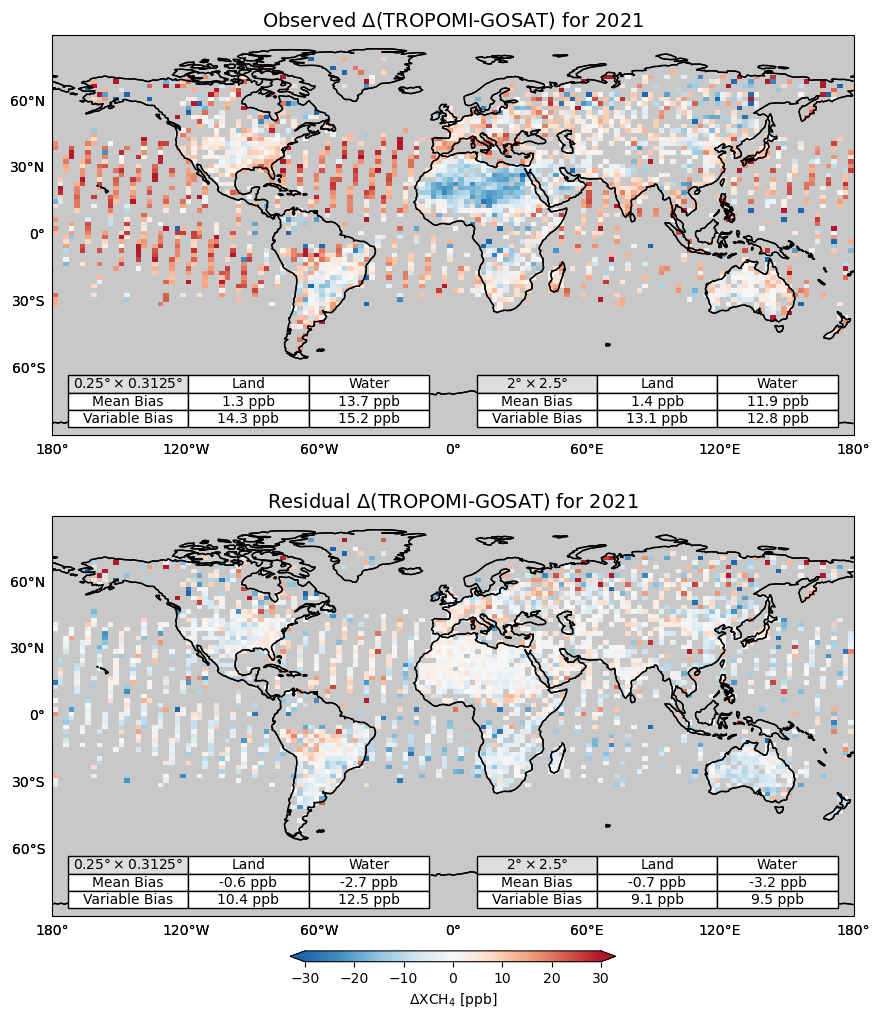

In [11]:
start_time = time.time()
fig05 = figure05()
print(f"Figure 05 generated in {(time.time()-start_time)/3600:.2f} hours.")
fig05.savefig(os.path.join(config["RunDir"], "notebooks", "paper_figures", "fig05.png"), bbox_inches="tight", dpi=300)

### Figure 6

In [12]:
def figure06():

    # Regrid SWIR surface albedo to 1.0 x 1.0 grid for all of 2021
    satellite_var_name = "surface_albedo_SWIR"
    extent = (-179.5,179.5,-89.5,89.5) # lon_min, lon_max, lat_min, lat_max
    res = (1.0,1.0) # lon, lat
    start_dt, end_dt = pd.to_datetime("2021-01-01 00:00:00"), pd.to_datetime("2022-01-01 00:00:00")
    regridded_SWIR_albedo_2021, regridded_SWIR_albedo_2021_n, lon_centers_grid, lat_centers_grid = regrid_satellite_variable_onto_regular_grid(satellite_var_name, extent, res, start_dt, end_dt)

    # Plot SWIR surface albedo + location of TCCON station
    fig,ax = plt.subplots(figsize=(10,10), subplot_kw={"projection":ccrs.PlateCarree()})
    ax.imshow(np.tile(np.array([[[200, 200, 200]]],dtype=np.uint8), [2, 2, 1]),origin='upper',transform=ccrs.PlateCarree(),extent=[-180, 180, -90, 90])
    ax.coastlines(linewidth=0.5)
    ax.set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, zorder=-1, linewidth=0)
    gl.top_labels = gl.right_labels = False

    cb = ax.pcolormesh(lon_centers_grid, lat_centers_grid, regridded_SWIR_albedo_2021, cmap=tol_cmap("rainbow_PuBr"), vmin=0.0, vmax=0.6)
    cbar = plt.colorbar(cb, location="bottom", aspect=30, pad=0.052, shrink=0.5, extend="both")
    cbar.ax.tick_params(labelsize=12)
    cbar.ax.set_xlabel("SWIR Surface Albedo", fontsize=12)

    # Get the list of TCCON files we considered
    tccon_dir = os.path.join(config['StorageDir'], 'tccon')
    tccon_files = glob.glob(os.path.join(tccon_dir, "*.nc"))
    tccon_files = [tccon_file for tccon_file in tccon_files
               if pd.Interval(pd.to_datetime(Dataset(tccon_file)["time"][:], unit="s").min(),
                               pd.to_datetime(Dataset(tccon_file)["time"][:], unit="s").max())
                   .overlaps(pd.Interval(pd.to_datetime('2018-04-30 00:00'),
                                          pd.to_datetime('2021-12-31 23:59')))]

    # Plot the coordinates of those TCCON stations
    for tccon_file in tccon_files:
        df = get_tccon_df(tccon_file)
        ax.scatter(df["longitude"].iloc[0], df["latitude"].iloc[0], marker="o", color="red", edgecolor="k", s=50, zorder=51)

    return fig

Figure 06 generated in 0.87 hours.


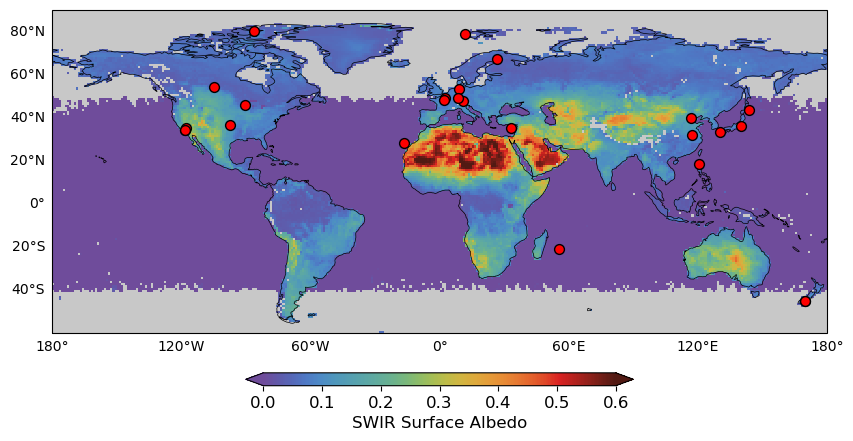

In [13]:
start_time = time.time()
fig06 = figure06()
print(f"Figure 06 generated in {(time.time()-start_time)/3600:.2f} hours.")
fig06.savefig(os.path.join(config["RunDir"], "notebooks", "paper_figures", "fig06.png"), bbox_inches="tight", dpi=300)

### Figure 7

In [2]:
def figure07():
    
    # Read in ∆(TROPOMI-TCCON) data
    with open(os.path.join(config["StorageDir"], "processed", f'delta_tropomi_tccon.pkl'), "rb") as handle:
        dict_delta_tropomi_tccon = pickle.load(handle)
        
    # Concatenate it all together and exclude some outliers so the axes limits are reasonable
    df = pd.concat([dict_delta_tropomi_tccon[key] for key in dict_delta_tropomi_tccon.keys() if (len(dict_delta_tropomi_tccon[key]) > 100)]).reset_index(drop=True)
    mask = (df.delta_tropomi_tccon > -150) & (df.delta_tropomi_tccon < 150)
    df = df[mask]
    print(f"Not showing {np.sum(~mask)} outliers.")
    
    # Plot the data
    fig,ax = plt.subplots(2,2, figsize=(17,10), sharey=True)
    cb = ax[0,0].hexbin(df.tropomi_surface_albedo_SWIR,df.delta_tropomi_tccon,bins="log",vmin=1,vmax=2e3,cmap=tol_cmap("rainbow_PuBr"))
    ax[0,1].hexbin(df.tropomi_surface_albedo_SWIR,df.delta_blended_tccon,bins="log",vmin=1,vmax=2e3,cmap=tol_cmap("rainbow_PuBr"))
    ax[1,0].hexbin(df.tropomi_aerosol_size,df.delta_tropomi_tccon,bins="log",vmin=1,vmax=2e3,cmap=tol_cmap("rainbow_PuBr"))
    ax[1,1].hexbin(df.tropomi_aerosol_size,df.delta_blended_tccon,bins="log",vmin=1,vmax=2e3,cmap=tol_cmap("rainbow_PuBr"))

    for i in [0,1]:
        ax[0,i].set_xlabel(f"TROPOMI SWIR Surface Albedo", fontsize=13)
        ax[1,i].set_xlabel(f"TROPOMI Aerosol Size Parameter", fontsize=13)
        ax[0,0].set_title("TROPOMI v02.04.00", fontsize=14, fontweight="bold")
        ax[0,1].set_title("Blended TROPOMI+GOSAT", fontsize=14, fontweight="bold")
        ax[i,0].set_ylabel(f"$\Delta$(satellite-TCCON) [ppb]", fontsize=13)

    # Plot the OLR fits
    slope_albedo_tropomi, intercept_albedo_tropomi, _, _, _ = linregress(df.tropomi_surface_albedo_SWIR, df.delta_tropomi_tccon)
    slope_albedo_blended, intercept_albedo_blended, _, _, _ = linregress(df.tropomi_surface_albedo_SWIR, df.delta_blended_tccon)
    albedo_xlim = np.array(ax[0,0].get_xlim())
    ax[0,0].plot(albedo_xlim,intercept_albedo_tropomi + slope_albedo_tropomi*albedo_xlim, color="k", linestyle="-", label="OLR Fit")
    ax[0,1].plot(albedo_xlim,intercept_albedo_blended + slope_albedo_blended*albedo_xlim, color="k", linestyle="-")
    ax[0,0].text(0.57,0.85,f"OLR Slope = {slope_albedo_tropomi:.1f} ppb", transform=ax[0,0].transAxes, fontsize=13)
    ax[0,1].text(0.57,0.85,f"OLR Slope = {slope_albedo_blended:.1f} ppb", transform=ax[0,1].transAxes, fontsize=13)

    slope_aerosol_tropomi, intercept_aerosol_tropomi, _, _, _ = linregress(df.tropomi_aerosol_size, df.delta_tropomi_tccon)
    slope_aerosol_blended, intercept_aerosol_blended, _, _, _ = linregress(df.tropomi_aerosol_size, df.delta_blended_tccon)
    aerosol_xlim = np.array(ax[1,0].get_xlim())
    ax[1,0].plot(aerosol_xlim,intercept_aerosol_tropomi + slope_aerosol_tropomi*aerosol_xlim, color="k", linestyle="-", label="OLR Fit")
    ax[1,1].plot(aerosol_xlim,intercept_aerosol_blended + slope_aerosol_blended*aerosol_xlim, color="k", linestyle="-")
    ax[1,0].text(0.57,0.85,f"OLR Slope = {slope_aerosol_tropomi:.1f} ppb", transform=ax[1,0].transAxes, fontsize=13)
    ax[1,1].text(0.57,0.85,f"OLR Slope = {slope_aerosol_blended:.1f} ppb", transform=ax[1,1].transAxes, fontsize=13)

    for i in [0,1]:
        for j in [0,1]:
            ax[i,j].tick_params(top=True,right=True)
            ax[i,j].axhline(0,linestyle="--",color="gray",zorder=0,linewidth=1, label="0 ppb")

    fig.subplots_adjust(wspace=0.05)
    plt.colorbar(cb, ax=ax, pad=0.03, shrink=0.5).set_label(label="Counts", size=13)
    ax[0,0].legend(loc="lower right", fontsize=12)
    
    return fig

Not showing 21 outliers.
Figure 07 generated in 0.01 hours.


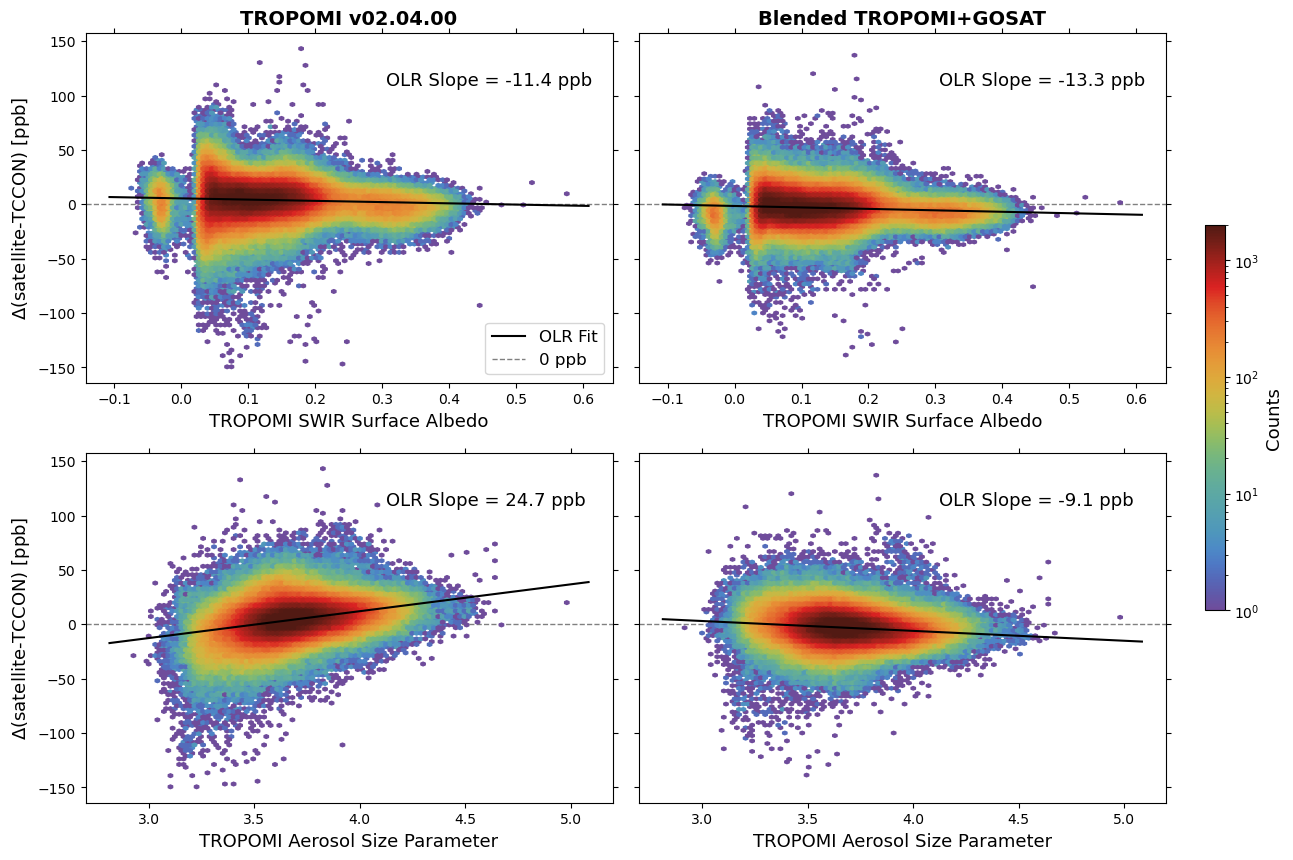

In [3]:
start_time = time.time()
fig07 = figure07()
print(f"Figure 07 generated in {(time.time()-start_time)/3600:.2f} hours.")
fig07.savefig(os.path.join(config["RunDir"], "notebooks", "paper_figures", "fig07.png"), bbox_inches="tight", dpi=300)

### Figure 8

In [2]:
def figure08():
    
    # Regrid xch4_blended and xch4_corrected to 1.0 x 1.0 grid for all of 2021
    satellite_var_name1 = "methane_mixing_ratio_blended"
    satellite_var_name2 = "methane_mixing_ratio_bias_corrected"
    extent = (-179.5,179.5,-89.5,89.5) # lon_min, lon_max, lat_min, lat_max
    res = (1.0,1.0) # lon, lat
    start_dt, end_dt = pd.to_datetime("2021-01-01 00:00:00"), pd.to_datetime("2022-01-01 00:00:00")
    regridded_xch4_blended_2021, regridded_xch4_blended_2021_n, lon_centers_grid, lat_centers_grid = regrid_satellite_variable_onto_regular_grid(satellite_var_name1, extent, res, start_dt, end_dt)
    regridded_xch4_corrected_2021, regridded_xch4_corrected_2021_n, _, _ = regrid_satellite_variable_onto_regular_grid(satellite_var_name2, extent, res, start_dt, end_dt)
    
    # General plot formatting
    fig,ax = plt.subplots(2,1,figsize=(12,12), subplot_kw={"projection":ccrs.PlateCarree()})
    for i in [0,1]:
        ax[i].coastlines()
        ax[i].set_global()
        gl = ax[i].gridlines(draw_labels=True, zorder=-1, linewidth=0)
        gl.top_labels = gl.right_labels = False
        ax[i].imshow(np.tile(np.array([[[200, 200, 200]]],dtype=np.uint8), [2, 2, 1]),origin='upper',transform=ccrs.PlateCarree(),extent=[-180, 180, -90, 90])
        ax[i].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())

    # Plot the regridded variables
    cb = ax[0].pcolormesh(lon_centers_grid, lat_centers_grid, regridded_xch4_blended_2021, cmap=tol_cmap("rainbow_PuBr"), vmin=1775, vmax=1925)
    plt.colorbar(cb, ax=ax[0], location="right", shrink=0.5, label="XCH$_4$ [ppb]", extend="both")
    cb = ax[1].pcolormesh(lon_centers_grid, lat_centers_grid, regridded_xch4_blended_2021-regridded_xch4_corrected_2021, cmap=tol_cmap("BuRd"), vmin=-30, vmax=30)
    plt.colorbar(cb, ax=ax[1], location="right", shrink=0.5, label="$\Delta$XCH$_4$ [ppb]", extend="both")

    ax[0].set_title("Blended TROPOMI+GOSAT XCH$_4$ for 2021",fontsize=13)
    ax[1].set_title("Correction to TROPOMI v02.04.00 product for 2021",fontsize=13)

    fig.subplots_adjust(hspace=-0.3)

    return fig

Figure 08 generated in 1.17 hours.


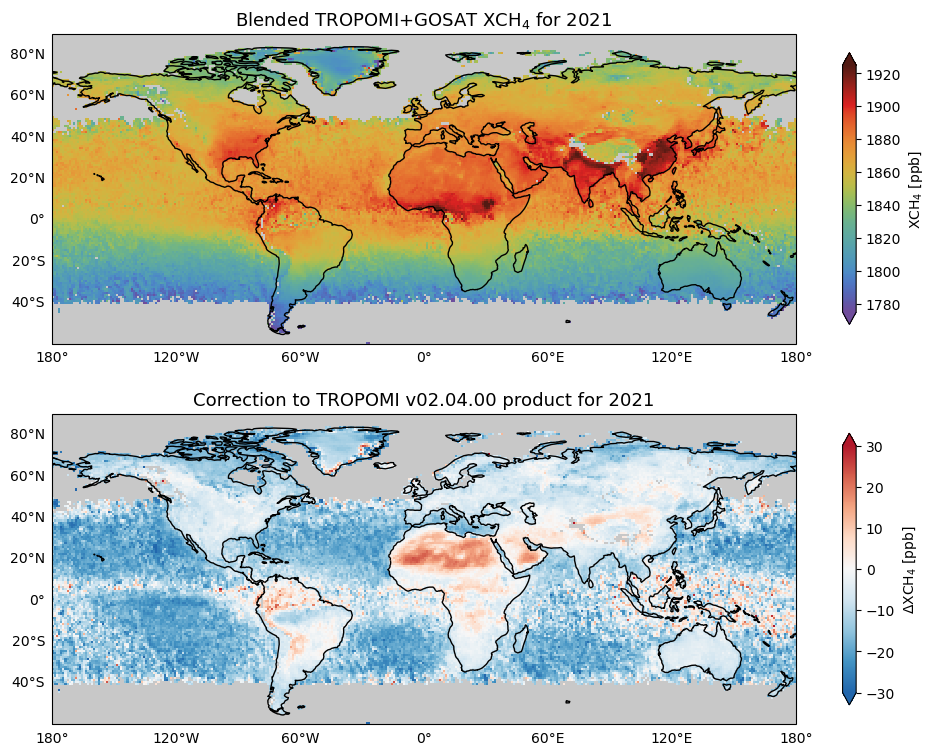

In [3]:
start_time = time.time()
fig08 = figure08()
print(f"Figure 08 generated in {(time.time()-start_time)/3600:.2f} hours.")
fig08.savefig(os.path.join(config["RunDir"], "notebooks", "paper_figures", "fig08.png"), bbox_inches="tight", dpi=300)

### Figure 9

In [16]:
def figure09():

    # Regrid xch4_blended and xch4_corrected to 1.0 x 1.0 grid for each season of 2021
    satellite_var_name1 = "methane_mixing_ratio_blended"
    satellite_var_name2 = "methane_mixing_ratio_bias_corrected"
    extent = (-179.5,179.5,-89.5,89.5) # lon_min, lon_max, lat_min, lat_max
    res = (1.0,1.0) # lon, lat
    start_dt1, end_dt1 = pd.to_datetime("2021-01-01 00:00:00"), pd.to_datetime("2021-04-01 00:00:00")
    start_dt2, end_dt2 = pd.to_datetime("2021-04-01 00:00:00"), pd.to_datetime("2021-07-01 00:00:00")
    start_dt3, end_dt3 = pd.to_datetime("2021-07-01 00:00:00"), pd.to_datetime("2021-10-01 00:00:00")
    start_dt4, end_dt4 = pd.to_datetime("2021-10-01 00:00:00"), pd.to_datetime("2022-01-01 00:00:00")

    regridded_xch4_blended_JFM_2021, regridded_xch4_blended_JFM_2021_n, lon_centers_grid, lat_centers_grid = regrid_satellite_variable_onto_regular_grid(satellite_var_name1, extent, res, start_dt1, end_dt1)
    regridded_xch4_corrected_JFM_2021, regridded_xch4_corrected_JFM_2021_n, _, _ = regrid_satellite_variable_onto_regular_grid(satellite_var_name2, extent, res, start_dt1, end_dt1)

    regridded_xch4_blended_AMJ_2021, regridded_xch4_blended_AMJ_2021_n, _, _ = regrid_satellite_variable_onto_regular_grid(satellite_var_name1, extent, res, start_dt2, end_dt2)
    regridded_xch4_corrected_AMJ_2021, regridded_xch4_corrected_AMJ_2021_n, _, _ = regrid_satellite_variable_onto_regular_grid(satellite_var_name2, extent, res, start_dt2, end_dt2)

    regridded_xch4_blended_JAS_2021, regridded_xch4_blended_JAS_2021_n, _, _ = regrid_satellite_variable_onto_regular_grid(satellite_var_name1, extent, res, start_dt3, end_dt3)
    regridded_xch4_corrected_JAS_2021, regridded_xch4_corrected_JAS_2021_n, _, _ = regrid_satellite_variable_onto_regular_grid(satellite_var_name2, extent, res, start_dt3, end_dt3)

    regridded_xch4_blended_OND_2021, regridded_xch4_blended_OND_2021_n, _, _ = regrid_satellite_variable_onto_regular_grid(satellite_var_name1, extent, res, start_dt4, end_dt4)
    regridded_xch4_corrected_OND_2021, regridded_xch4_corrected_OND_2021_n, _, _ = regrid_satellite_variable_onto_regular_grid(satellite_var_name2, extent, res, start_dt4, end_dt4)

    # General plot formatting
    fig,ax = plt.subplots(2,2, figsize=(15,12), subplot_kw={"projection":ccrs.PlateCarree()})
    for i in [0,1]: # add gray background
        for j in [0,1]:
            ax[i,j].imshow(np.tile(np.array([[[200, 200, 200]]],dtype=np.uint8), [2, 2, 1]),origin='upper',transform=ccrs.PlateCarree(),extent=[-180, 180, -90, 90])

    ax[0,0].pcolormesh(lon_centers_grid, lat_centers_grid, regridded_xch4_blended_JFM_2021-regridded_xch4_corrected_JFM_2021, cmap=tol_cmap("BuRd"), vmin=-30, vmax=30)
    ax[0,0].set_title("January February March", fontsize=13)

    ax[0,1].pcolormesh(lon_centers_grid, lat_centers_grid, regridded_xch4_blended_AMJ_2021-regridded_xch4_corrected_AMJ_2021, cmap=tol_cmap("BuRd"), vmin=-30, vmax=30)
    ax[0,1].set_title("April May June", fontsize=13)

    ax[1,0].pcolormesh(lon_centers_grid, lat_centers_grid, regridded_xch4_blended_JAS_2021-regridded_xch4_corrected_JAS_2021, cmap=tol_cmap("BuRd"), vmin=-30, vmax=30)
    ax[1,0].set_title("July August September", fontsize=13)

    ax[1,1].pcolormesh(lon_centers_grid, lat_centers_grid, regridded_xch4_blended_OND_2021-regridded_xch4_corrected_OND_2021, cmap=tol_cmap("BuRd"), vmin=-30, vmax=30)
    ax[1,1].set_title("October November December", fontsize=13)

    # Further plot formatting
    for i in [0,1]:
        for j in [0,1]:
                ax[i,j].coastlines()
                ax[i,j].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())
                gl = ax[i,j].gridlines(draw_labels=True, zorder=-1, linewidth=0)
                gl.top_labels = gl.right_labels = False
                if i == 0:
                    gl.bottom_labels = False
                if j == 1:
                    gl.left_labels = False

    # Adjust spacing and add a colorbar
    fig.subplots_adjust(hspace=-0.4,wspace=0.1)
    cbar = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=-30, vmax=30), cmap=tol_cmap("BuRd"))
    cb = fig.colorbar(cbar, ax=ax, location="bottom", aspect=30.0, pad=0.042, shrink=0.4, extend="both")
    cb.set_label(f"$\Delta$XCH$_4$ [ppb]", fontsize=12)
    cb.ax.tick_params(labelsize=12) 

    return fig

Figure 09 generated in 1.79 hours.


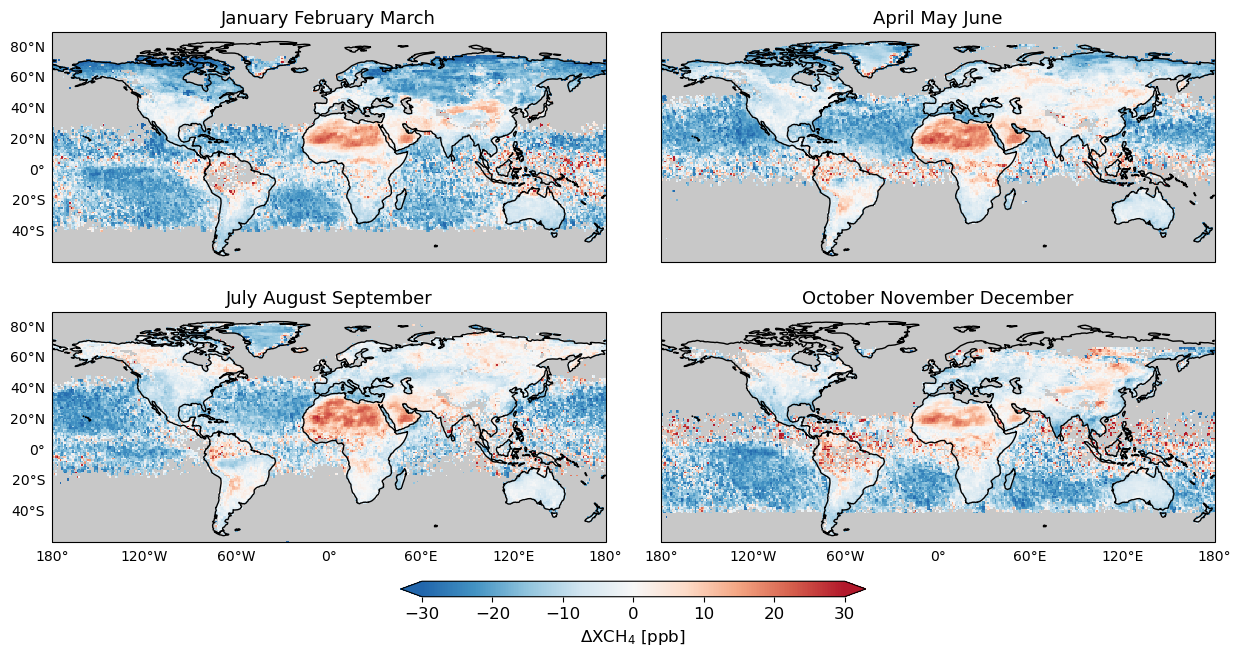

In [17]:
start_time = time.time()
fig09 = figure09()
print(f"Figure 09 generated in {(time.time()-start_time)/3600:.2f} hours.")
fig09.savefig(os.path.join(config["RunDir"], "notebooks", "paper_figures", "fig09.png"), bbox_inches="tight", dpi=300)

### Figure 10

In [ ]:
def figure10():

    # Read in the oversampled data from tools/oversample
    basename,res,extent = "TROPOMI_NorthAfrica_2021",0.01,[25,65,8,35]

    blended = pd.read_fwf(os.path.join(config["StorageDir"], "oversample", "output", f"{basename}_Blended_oversampled{res}.csv"), header=None, widths=[6,6,12,12,15,6], names=["row","col","lat","lon","methane_mixing_ratio_blended","n"], usecols=["lat","lon","methane_mixing_ratio_blended","n"])
    operational = pd.read_fwf(os.path.join(config["StorageDir"], "oversample", "output", f"{basename}_Operational_oversampled{res}.csv"), header=None, widths=[6,6,12,12,15,6], names=["row","col","lat","lon","methane_mixing_ratio_bias_corrected","n"], usecols=["lat","lon","methane_mixing_ratio_bias_corrected","n"])
    albedo = pd.read_fwf(os.path.join(config["StorageDir"], "oversample", "output", f"{basename}_SWIR_Surface_Albedo_oversampled{res}.csv"), header=None, widths=[6,6,12,12,15,6], names=["row","col","lat","lon","surface_albedo_SWIR","n"], usecols=["lat","lon","surface_albedo_SWIR","n"])
    aerosol = pd.read_fwf(os.path.join(config["StorageDir"], "oversample", "output", f"{basename}_Aerosol_Size_oversampled{res}.csv"), header=None, widths=[6,6,12,12,15,6], names=["row","col","lat","lon","aerosol_size","n"], usecols=["lat","lon","aerosol_size","n"])

    patches = []
    for i in blended.index:
        lon = blended.loc[i,"lon"]
        lat = blended.loc[i,"lat"]
        xmin = lon - res/2
        xmax = lon + res/2
        ymin = lat - res/2
        ymax = lat + res/2
        patches.append(Polygon(np.array(((xmin,ymin),(xmin,ymax),(xmax,ymax),(xmax,ymin)))))
        
    # Create patch collections, masking those grid cells with less than 10 satellite observation layers
    mask = (blended["n"] >= 10)
    patches_array = np.array(patches)[mask]

    blended_collection = PatchCollection(patches_array, array=blended["methane_mixing_ratio_blended"][mask], cmap=tol_cmap("rainbow_PuBr"))
    blended_collection.set_clim(vmin=1850,vmax=1925)

    operational_collection = PatchCollection(patches_array, array=operational["methane_mixing_ratio_bias_corrected"][mask], cmap=tol_cmap("rainbow_PuBr"))
    operational_collection.set_clim(vmin=1850,vmax=1925)

    albedo_collection = PatchCollection(patches_array, array=albedo["surface_albedo_SWIR"][mask], cmap=tol_cmap("rainbow_PuBr"))
    albedo_collection.set_clim(vmin=0,vmax=0.6)

    aerosol_collection = PatchCollection(patches_array, array=aerosol["aerosol_size"][mask], cmap=tol_cmap("rainbow_PuBr"))
    aerosol_collection.set_clim(vmin=3.2,vmax=3.8)
    
    # Plot the oversampled data
    fig,ax = plt.subplots(2,2, figsize=(13,12), subplot_kw={"projection":ccrs.PlateCarree()})

    # Add grey background
    for i in [0,1]:
        for j in [0,1]:
            ax[i,j].imshow(np.tile(np.array([[[200, 200, 200]]],dtype=np.uint8), [2, 2, 1]),origin='upper',transform=ccrs.PlateCarree(),extent=[-180, 180, -90, 90])

    ax[0,0].add_collection(operational_collection)
    ax[0,0].set_title("TROPOMI v02.04.00",fontsize=13)
    plt.colorbar(operational_collection, ax=ax[0,0], label=f"XCH$_4$ [ppb]", extend="both", shrink=0.45)

    ax[0,1].add_collection(blended_collection)
    ax[0,1].set_title("Blended TROPOMI+GOSAT",fontsize=13)
    plt.colorbar(blended_collection, ax=ax[0,1], label=f"XCH$_4$ [ppb]", extend="both", shrink=0.45)

    ax[1,0].add_collection(aerosol_collection)
    ax[1,0].set_title("TROPOMI Aerosol Size Parameter",fontsize=13)
    plt.colorbar(aerosol_collection, ax=ax[1,0], label=f"Aerosol Size Distribution Parameter", extend="both", shrink=0.45)

    ax[1,1].add_collection(albedo_collection)
    ax[1,1].set_title("TROPOMI SWIR Surface Albedo",fontsize=13)
    plt.colorbar(albedo_collection, ax=ax[1,1], label=f"SWIR Surface Albedo", extend="both", shrink=0.45)

    for i in [0,1]:
        for j in [0,1]:
            ax[i,j].coastlines(linewidth=0.3,linestyle="--")
            ax[i,j].set_extent(extent, crs=ccrs.PlateCarree())
            ax[i,j].add_feature(cf.BORDERS, linewidth=0.3, linestyle="--")
            gl = ax[i,j].gridlines(draw_labels=True, zorder=-1, linewidth=0)
            gl.top_labels = gl.right_labels = False

    fig.subplots_adjust(hspace=-0.47,wspace=0.15)

    return fig

In [ ]:
start_time = time.time()
fig10 = figure10()
print(f"Figure 10 generated in {(time.time()-start_time)/3600:.2f} hours.")
fig10.savefig(os.path.join(config["RunDir"], "notebooks", "paper_figures", "fig10.png"), bbox_inches="tight", dpi=300)

### Figure 11

In [6]:
def figure11():

    # File from Kayrros, referenced to get the white dot in the center for approximate emitter location
    if os.path.exists("../tools/S5P_ultra_emitters_2019_2020.csv"):
        events = pd.read_csv("../tools/S5P_ultra_emitters_2019_2020.csv")
        print(events.iloc[274])

    file = [f for f in glob.glob(os.path.join(config["StorageDir"], "blended", "*.nc")) if "_11252_" in f][0]
    extent = [3, 9, 29, 35]
    shrink = 0.5
    ds = Dataset(file)
    xch4_corrected, xch4_blended, cirrus, lat_center, lon_center, lat_corners, lon_corners = [
        ds["methane_mixing_ratio_bias_corrected"][:], ds["methane_mixing_ratio_blended"][:], ds["reflectance_cirrus_VIIRS_SWIR"][:], 
        ds["latitude"][:], ds["longitude"][:], ds["latitude_bounds"][:], ds["longitude_bounds"][:]
    ]

    verts = [np.array([lon_corners[i,:],lat_corners[i,:]]).T for i in range(len(xch4_corrected))]

    cmaps = ["rainbow_PuBr", "rainbow_PuBr", "rainbow_PuBr", "BuRd"]
    titles = ["TROPOMI v02.04.00", "Blended TROPOMI+GOSAT", "VIIRS Cirrus Reflectance", "Correction to TROPOMI v02.04.00"]
    arrays = [xch4_corrected, xch4_blended, cirrus, xch4_blended - xch4_corrected]
    vmins, vmaxs = [1830, 1830, 0, -30], [1880, 1880, 0.005, 30]
    cbar_labels = ["XCH$_4$ [ppb]", "XCH$_4$ [ppb]", "Cirrus Reflectance", "$\Delta$XCH$_4$ [ppb]"]

    fig, ax = plt.subplots(2, 2, figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()})

    for i in range(4):
        pc = PolyCollection(verts, array=arrays[i], cmap=tol_cmap(cmaps[i]))
        pc.set_clim(vmin=vmins[i], vmax=vmaxs[i])
        ax[i//2, i%2].imshow(np.tile(np.array([[[220, 220, 220]]],dtype=np.uint8), [2, 2, 1]),origin='upper',transform=ccrs.PlateCarree(),extent=[-180, 180, -90, 90])
        ax[i//2, i%2].add_collection(pc)
        ax[i//2, i%2].set_title(titles[i])
        plt.colorbar(pc, ax=ax[i//2, i%2], label=cbar_labels[i], shrink=shrink, extend="both")
        ax[i//2, i%2].coastlines()
        ax[i//2, i%2].set_extent(extent, ccrs.PlateCarree())
        gl = ax[i//2, i%2].gridlines(draw_labels=True, zorder=-1, linewidth=0)
        gl.top_labels = gl.right_labels = False

        if os.path.exists("../tools/S5P_ultra_emitters_2019_2020.csv"):
            ax[i//2, i%2].scatter(events.loc[274, "source_longitude_rough"], events.loc[274, "source_latitude_rough"], marker=".", color="w", s=250, edgecolor="k")

    fig.tight_layout()
    fig.subplots_adjust(hspace=-0.3)
    
    return fig

date                        2019-12-15
event_id                          1296
emissions_rate_tons_hour           NaN
category                            og
source_latitude_rough            32.15
source_longitude_rough            6.14
Name: 274, dtype: object
Figure 11 generated in 0.00 hours.


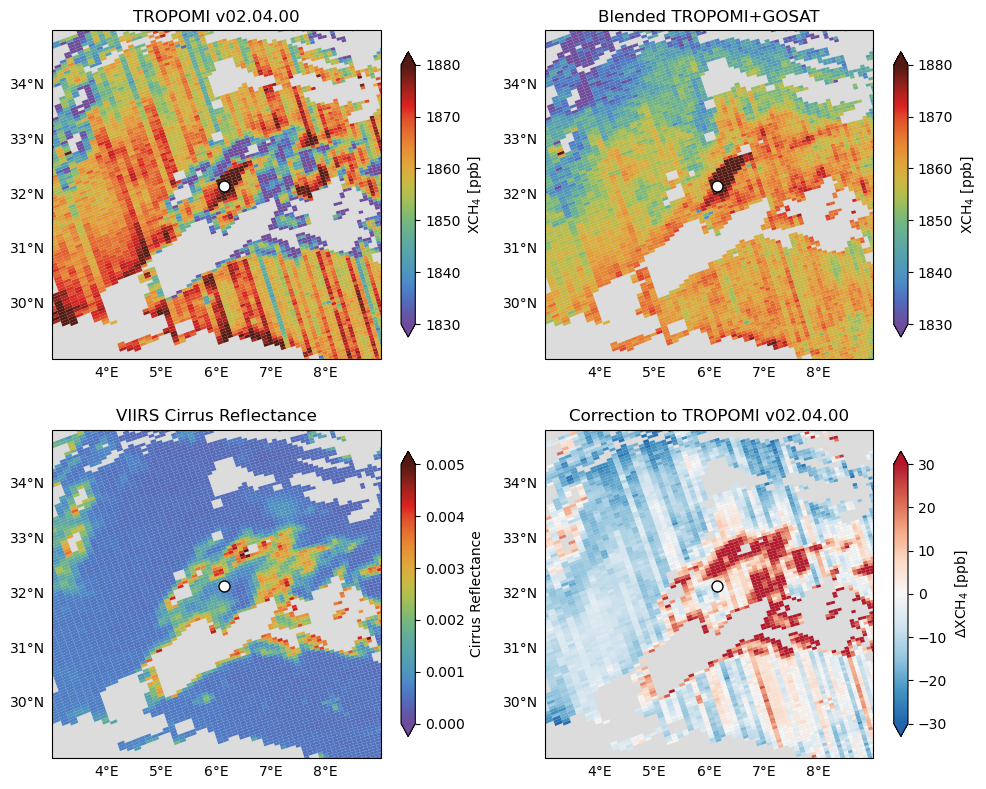

In [7]:
start_time = time.time()
fig11 = figure11()
print(f"Figure 11 generated in {(time.time()-start_time)/3600:.2f} hours.")
fig11.savefig(os.path.join(config["RunDir"], "notebooks", "paper_figures", "fig11.png"), bbox_inches="tight", dpi=300)

### Table B2

In [71]:
def tableB2():

    # Read in gosat + tccon pairs
    with open(os.path.join(config["StorageDir"], "processed", "delta_gosat_tccon.pkl"), "rb") as handle:
        delta_gosat_tccon = pickle.load(handle)

    # Read in tropomi + tccon pairs
    with open(os.path.join(config["StorageDir"], "processed", "delta_tropomi_tccon.pkl"), "rb") as handle:
        delta_tropomi_tccon = pickle.load(handle)
        
    # Build dataframe analogous to table b2
    cols = [('GOSAT', '\u03BC'), ('GOSAT', '\u03C3'), ('TROPOMI', '\u03BC'), ('TROPOMI', '\u03C3'), ('Blended', '\u03BC'), ('Blended', '\u03C3')]
    df = pd.DataFrame(columns=pd.MultiIndex.from_tuples(cols))

    # Get the list of TCCON files we considered
    tccon_dir = os.path.join(config['StorageDir'], 'tccon')
    tccon_files = glob.glob(os.path.join(tccon_dir, "*.nc"))
    tccon_files = [tccon_file for tccon_file in tccon_files
               if pd.Interval(pd.to_datetime(Dataset(tccon_file)["time"][:], unit="s").min(),
                               pd.to_datetime(Dataset(tccon_file)["time"][:], unit="s").max())
                   .overlaps(pd.Interval(pd.to_datetime('2018-04-30 00:00'),
                                          pd.to_datetime('2021-12-31 23:59')))]
    station_names = []
    for f in tccon_files:
        with Dataset(f) as ds:
            station_names.append(ds.long_name)

    # Remove numbers from name and merge the lauder02 and lauder03
    stations_cleaned = []
    for station in station_names:
        station_cleaned = re.sub('\d+', '', station)
        if station_cleaned not in stations_cleaned:
            stations_cleaned.append(station_cleaned)

    df["Station Name"] = (stations_cleaned)
    df = df.set_index("Station Name")
    
    # Add GOSAT station metrics
    for key in delta_gosat_tccon.keys():
    
        if key == "lauder02":
            continue
        elif key == "lauder03":
            station_df = pd.concat([delta_gosat_tccon["lauder02"],delta_gosat_tccon["lauder03"]])
        else:
            station_df = delta_gosat_tccon[key]

        if len(station_df) > 100:
            station_name = re.sub('\d+', '', key)
            df["GOSAT","\u03BC"].loc[station_name] = (station_df["delta_gosat_tccon"]-config["GlobalOffsetGOSAT"]).mean()
            df["GOSAT","\u03C3"].loc[station_name] = (station_df["delta_gosat_tccon"]-config["GlobalOffsetGOSAT"]).std()
       
    # Add TROPOMI+Blended station metrics
    for key in delta_tropomi_tccon.keys():
    
        if key == "lauder02":
            continue
        elif key == "lauder03":
            station_df = pd.concat([delta_tropomi_tccon["lauder02"],delta_tropomi_tccon["lauder03"]])
        else:
            station_df = delta_tropomi_tccon[key]

        if len(station_df) > 1000:
            station_name = re.sub('\d+', '', key)
            df["TROPOMI","\u03BC"].loc[station_name] = station_df["delta_tropomi_tccon"].mean()
            df["TROPOMI","\u03C3"].loc[station_name] = station_df["delta_tropomi_tccon"].std()
            df["Blended","\u03BC"].loc[station_name] = station_df["delta_blended_tccon"].mean()
            df["Blended","\u03C3"].loc[station_name] = station_df["delta_blended_tccon"].std()
            
    return df

In [72]:
start_time = time.time()
df = tableB2()
print(f"Figure B2 generated in {(time.time()-start_time)/3600:.2f} hours.")
df.sort_values("Station Name").astype(float).round(1)

Figure B2 generated in 0.01 hours.


GOSAT       TROPOMI       Blended      
                  μ     σ       μ     σ       μ     σ
Station Name                                         
bremen          0.3  14.3     7.6  13.4    -2.3   9.7
burgos         -1.2  11.0     6.6  15.0    -8.1   9.8
easttroutlake   1.6  18.6    10.4  20.7     4.2  14.0
edwards        -1.4  10.6    -0.9  10.2    -7.4   8.0
eureka         14.2  20.2    17.3  15.6    -2.3  16.5
garmisch        0.8  15.9    13.1  15.1     6.3  13.3
hefei           3.0  21.3     7.0  13.1    -1.7  12.2
izana           NaN   NaN     NaN   NaN     NaN   NaN
jpl             NaN   NaN     NaN   NaN     NaN   NaN
karlsruhe      -3.9  14.8     4.6  14.2    -4.4  10.6
lamont         -0.5  14.0     2.6  12.1    -2.9  10.4
lauder         -1.7   9.7    -0.3  15.1    -8.9  10.9
nicosia        -0.6  12.6     5.2  13.4    -4.4  11.7
nyalesund       NaN   NaN     NaN   NaN     NaN   NaN
orleans        -1.2  12.6     5.3  12.6    -3.6   9.7
paris          -3.2  13.7     5.0  13.0    -3.8  10.9
parkfalls       3.0  15.3     2.7  17.2    -0.9  13.7
pasadena       -7.5  15.4     0.4  13.9   -11.7  11.8
reunion        -9.4  10.6     NaN   NaN     NaN   NaN
rikubetsu       9.9  17.0     8.3  15.5     3.2  13.2
saga           -2.1  14.6    12.9  13.1     0.3  12.2
sodankyla       1.6  16.4     4.9  19.9     0.3  12.9
tsukuba        -4.9  13.2     3.1  10.8    -4.0  10.1
xianghe         3.1  20.3     4.1  15.5    -5.4  15.6

In [73]:
for key in df.keys():
    if key[1] == "\u03BC":
        print(f"{key[0]} mean bias = {df[key].mean():.1f} ppb")
        print(f"{key[0]} variable bias = {df[key].std():.1f} ppb")
    if key[1] == "\u03C3":
        print(f"{key[0]} precision = {df[key].mean():.1f} ppb")
        if key[0] != "Blended":
            print()

GOSAT mean bias = 0.0 ppb
GOSAT variable bias = 5.2 ppb
GOSAT precision = 14.9 ppb

TROPOMI mean bias = 6.0 ppb
TROPOMI variable bias = 4.7 ppb
TROPOMI precision = 14.5 ppb

Blended mean bias = -2.9 ppb
Blended variable bias = 4.4 ppb
Blended precision = 11.9 ppb


### Figure C1

In [2]:
def figureC1():
    
    # Regrid xch4 and xch4_correctedto 1.0 x 1.0 grid for all of 2021
    satellite_var_name1 = "methane_mixing_ratio"
    satellite_var_name2 = "methane_mixing_ratio_bias_corrected"
    extent = (-179.5,179.5,-89.5,89.5) # lon_min, lon_max, lat_min, lat_max
    res = (1.0,1.0) # lon, lat
    start_dt, end_dt = pd.to_datetime("2021-01-01 00:00:00"), pd.to_datetime("2022-01-01 00:00:00")
    regridded_xch4_2021, regridded_xch4_2021_n, lon_centers_grid, lat_centers_grid = regrid_satellite_variable_onto_regular_grid(satellite_var_name1, extent, res, start_dt, end_dt)
    regridded_xch4_corrected_2021, regridded_xch4_corrected_2021_n, _, _ = regrid_satellite_variable_onto_regular_grid(satellite_var_name2, extent, res, start_dt, end_dt)

    fig,ax = plt.subplots(2,1,figsize=(12,12), subplot_kw={"projection":ccrs.PlateCarree()})
    for i in [0,1]:
        ax[i].coastlines()
        ax[i].set_global()
        gl = ax[i].gridlines(draw_labels=True, zorder=-1, linewidth=0)
        gl.top_labels = gl.right_labels = False
        ax[i].imshow(np.tile(np.array([[[200, 200, 200]]],dtype=np.uint8), [2, 2, 1]),origin='upper',transform=ccrs.PlateCarree(),extent=[-180, 180, -90, 90])
        ax[i].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())

    cb = ax[0].pcolormesh(lon_centers_grid, lat_centers_grid, regridded_xch4_2021, cmap=tol_cmap("rainbow_PuBr"), vmin=1775, vmax=1925)
    plt.colorbar(cb, ax=ax[0], location="right", shrink=0.5, label="XCH$_4$ [ppb]", extend="both")
    cb = ax[1].pcolormesh(lon_centers_grid, lat_centers_grid, regridded_xch4_corrected_2021-regridded_xch4_2021, cmap=tol_cmap("BuRd"), vmin=-30, vmax=30)
    plt.colorbar(cb, ax=ax[1], location="right", shrink=0.5, label="XCH$_4$ [ppb]", extend="both")

    ax[0].set_title('TROPOMI v02.04.00 "methane_mixing_ratio" for 2021',fontsize=13)
    ax[1].set_title('TROPOMI v02.04.00 "methane_mixing_ratio_bias_corrected" - "methane_mixing_raito" for 2021',fontsize=13)

    fig.subplots_adjust(hspace=-0.3)
    
    return fig

Figure C1 generated in 1.16 hours.


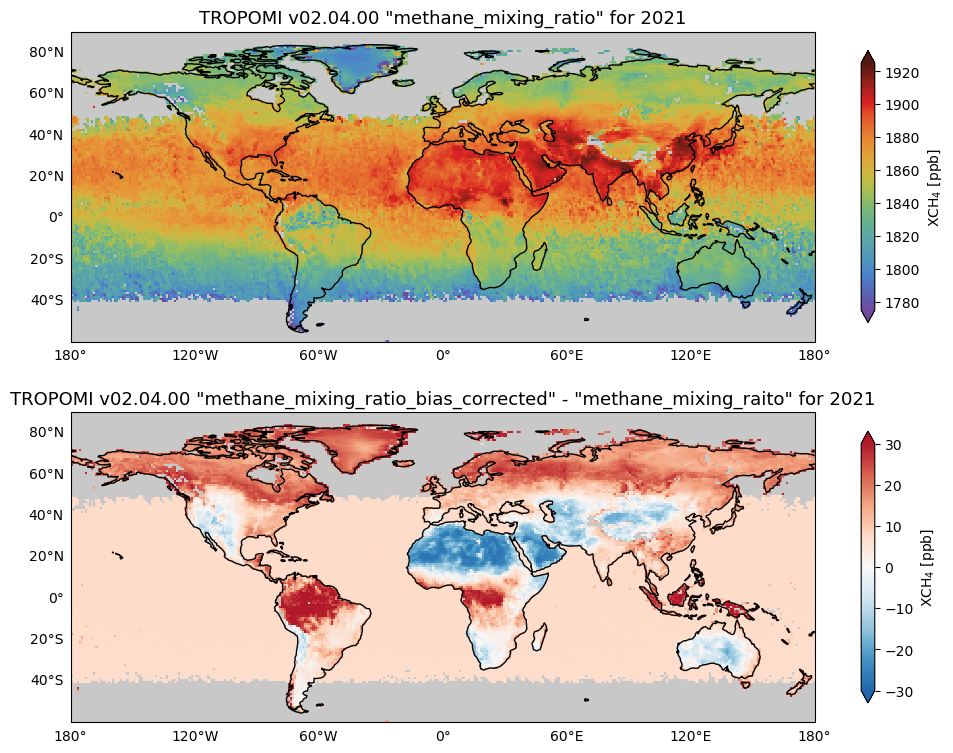

In [3]:
start_time = time.time()
figc1 = figureC1()
print(f"Figure C1 generated in {(time.time()-start_time)/3600:.2f} hours.")
figc1.savefig(os.path.join(config["RunDir"], "notebooks", "paper_figures", "figc1.png"), bbox_inches="tight", dpi=300)

### Figure D1

In [2]:
def figureD1():

    # Read in the oversampled data
    res,extent = 0.01,[-20,53,5,38]

    blended_all = pd.read_fwf(f"{config['StorageDir']}/oversample/output/TROPOMI_NorthAfrica_2021_Blended_oversampled{res}.csv", header=None, widths=[6,6,12,12,15,6], names=["row","col","lat","lon","methane_mixing_ratio_blended","n"], usecols=["lat","lon","methane_mixing_ratio_blended","n"])
    blended_filtered =  pd.read_fwf(f"{config['StorageDir']}/oversample/output/TROPOMI_NorthAfrica_Filter_2021_Blended_oversampled{res}.csv", header=None, widths=[6,6,12,12,15,6], names=["row","col","lat","lon","methane_mixing_ratio_blended","n"], usecols=["lat","lon","methane_mixing_ratio_blended","n"])

    patches_all = []
    for i in blended_all.index:
        lon = blended_all.loc[i,"lon"]
        lat = blended_all.loc[i,"lat"]
        xmin = lon - res/2
        xmax = lon + res/2
        ymin = lat - res/2
        ymax = lat + res/2
        patches_all.append(Polygon(np.array(((xmin,ymin),(xmin,ymax),(xmax,ymax),(xmax,ymin)))))

    mask_all = (blended_all["n"] >= 10)
    patches_all_array = np.array(patches_all)[mask_all]

    patches_filtered = []
    for i in blended_filtered.index:
        lon = blended_filtered.loc[i,"lon"]
        lat = blended_filtered.loc[i,"lat"]
        xmin = lon - res/2
        xmax = lon + res/2
        ymin = lat - res/2
        ymax = lat + res/2
        patches_filtered.append(Polygon(np.array(((xmin,ymin),(xmin,ymax),(xmax,ymax),(xmax,ymin)))))

    # Create patch collections and filter out grid cells with less than 10 layers of satellite observations
    mask_filtered = (blended_filtered["n"] >= 10)
    patches_filtered_array = np.array(patches_filtered)[mask_filtered]

    blended_collection = PatchCollection(patches_all_array, array=blended_all["methane_mixing_ratio_blended"][mask_all], cmap=tol_cmap("rainbow_PuBr"))
    blended_collection.set_clim(vmin=1850,vmax=1925)

    blended_filtered_collection = PatchCollection(patches_filtered_array, array=blended_filtered["methane_mixing_ratio_blended"][mask_filtered], cmap=tol_cmap("rainbow_PuBr"))
    blended_filtered_collection.set_clim(vmin=1850,vmax=1925)

    # Collect all of the filtered-out retrievals
    blended_files_2021 = [f for f in glob.glob(os.path.join(config["StorageDir"], "blended", "*.nc"))
                             if pd.Interval(pd.to_datetime(f.split("_")[12]), pd.to_datetime(f.split("_")[13])).
                             overlaps(pd.Interval(pd.to_datetime("2021-01-01 00:00:00"),pd.to_datetime("2022-01-01 00:00:00")))]

    filtered_retrievals = pd.DataFrame(columns=["lat","lon","xch4"])
    for blended_file in blended_files_2021:
        with Dataset(blended_file) as ds:
            tropomi_surface_classification = (ds["surface_classification"][:] & 0x03).astype(int)
            valid_idx = ((tropomi_surface_classification == 3) | ((tropomi_surface_classification == 2) & (ds["chi_square_SWIR"][:] > 20)))
            valid_idx &= ((ds["longitude"][:] > extent[0]) & (ds["longitude"][:] < extent[1]) & (ds["latitude"][:] > extent[2]) & (ds["latitude"][:] < extent[3]))
            temp_df = pd.DataFrame({"lat": ds["latitude"][:][valid_idx],
                                    "lon": ds["longitude"][:][valid_idx],
                                    "xch4": ds["methane_mixing_ratio_blended"][:][valid_idx]})
            filtered_retrievals = pd.concat([filtered_retrievals,temp_df])

    # Plot the pre-filter, filtered-out, and post-filter data
    fig,ax = plt.subplots(3,1, figsize=(10,20), subplot_kw={"projection":ccrs.PlateCarree()})

    for i in [0,1,2]:
        ax[i].imshow(np.tile(np.array([[[200, 200, 200]]],dtype=np.uint8), [2, 2, 1]),origin='upper',transform=ccrs.PlateCarree(),extent=[-180, 180, -90, 90])

    ax[0].add_collection(blended_collection)
    ax[0].set_title("Blended TROPOMI+GOSAT (Pre-Filter)",fontsize=13)

    cb = ax[1].scatter(filtered_retrievals["lon"],filtered_retrievals["lat"],c=filtered_retrievals["xch4"],cmap=tol_cmap("rainbow_PuBr"),vmin=1850,vmax=1925,s=1)
    ax[1].set_title("Filtered-out Retrievals", fontsize=13)

    ax[2].add_collection(blended_filtered_collection)
    ax[2].set_title("Blended TROPOMI+GOSAT (Post-Filter)",fontsize=13)

    plt.colorbar(cb, ax=ax, label=f"XCH$_4$ [ppb]", extend="both", location="bottom", pad=0.04, aspect=30)

    for i in [0,1,2]:
        ax[i].coastlines(linewidth=0.3,linestyle="--")
        ax[i].set_extent(extent, crs=ccrs.PlateCarree())
        ax[i].add_feature(cf.BORDERS, linewidth=0.3, linestyle="--")
        gl = ax[i].gridlines(draw_labels=True, zorder=-1, linewidth=0)
        gl.top_labels = gl.right_labels = False

    return fig

Figure D1 generated in 1.89 hours.


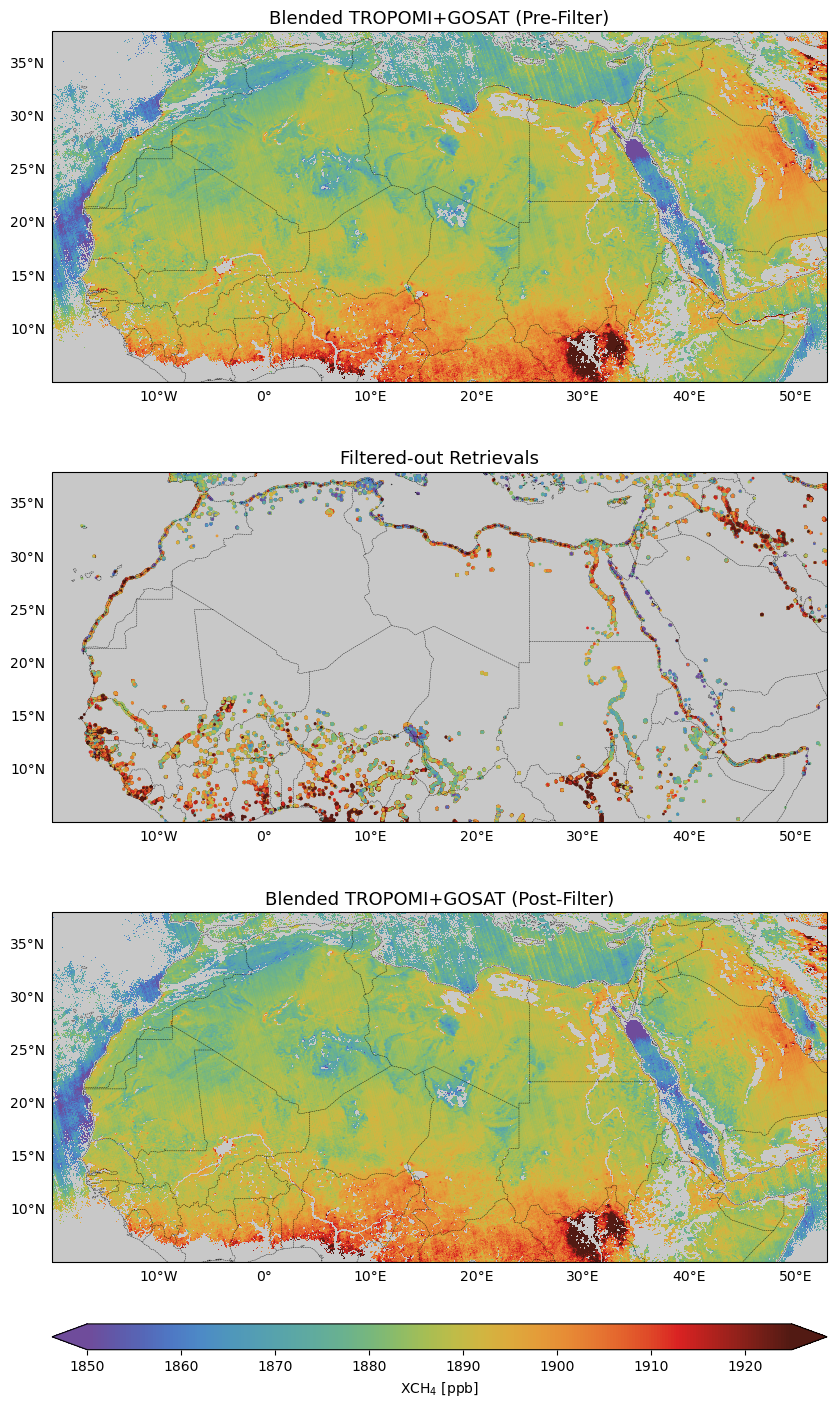

In [3]:
start_time = time.time()
figd1 = figureD1()
print(f"Figure D1 generated in {(time.time()-start_time)/3600:.2f} hours.")
figd1.savefig(os.path.join(config["RunDir"], "notebooks", "paper_figures", "figd1.png"), bbox_inches="tight", dpi=300)